# Publix BOGO Recipe Matcher

The goal of this notebook is to explore Publix BOGO items choices and improve weekly grocery shopping, by matching Publix BOGO deals with recipes that use the discounted ingredients.

## Overview
Publix offers "Buy One Get One" deals for ingredients that update weekly and vary by region. The Eight Portions recipe dataset (https://eightportions.com/datasets/Recipes/) is used and compared to the BOGO ingredients via NLP, to find the recipes with the most ingredients on sale for that week.

## In this project
1. BOGO items are scraped directly from the Publix website via Selenium and BeautifulSoup.
2. Recipes are loaded from zip file.
3. Data is cleaned and prepared for NLP.
4. Recipe embeddings are precomputed and stored, in order to lower subsequent run times.
5. Natural language processing (sentence_transformers) is used to match BOGO items to recipe ingredients.
6. Recipes are ranked by number of matches.
7. Data is explored and optimal meals are found.

## BOGO Web Scraping

Publix's ad page utilizes lazy loading, which means items won't be loaded until it is necessary for the customer. Selenium is used to open the web page and slowly scroll through the BOGO section in order to load all the items. At the same time, BeautifulSoup is used to find each item name in the section and store this in a list.

In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

def get_bogo():
    url = "https://www.publix.com/savings/weekly-ad/bogo"

    driver = webdriver.Chrome()
    driver.get(url)

    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, 'bogo-grid')))

    bogo_list = []
    bogo_url = driver.current_url

    scroll_pause = 2
    scroll_attempts = 0
    max_attempts = 15

    while scroll_attempts < max_attempts:
        soup = BeautifulSoup(driver.page_source, "lxml")
        grid = soup.find("div", id="bogo-grid")
        if grid:
            items = grid.find_all("span", class_="p-text paragraph-md normal context--default color--null line-clamp title")

            for item in items:
                title = item.get_text(strip=True)
                if title not in bogo_list:
                    bogo_list.append(title)

        if driver.current_url != bogo_url:
            break

        driver.execute_script("window.scrollBy(0, 1000);")
        time.sleep(scroll_pause)

    driver.quit()
    
    return bogo_list

## Load Recipes

Recipes are loaded from a publicly available .zip file from Eight Portions. This file includes recipes in a JSON format from three different food recipe websites. These recipes are loaded into a dataframe with the source included and pictures dropped, as they are unneccesary for this project. Recipes missing titles, instructions, or with empty or duplicate ingredient lists are removed.

In [14]:
import zipfile
import json
import pandas as pd

def get_recipes():
    files = ['recipes_raw_nosource_ar.json', 'recipes_raw_nosource_epi.json', 'recipes_raw_nosource_fn.json']

    dfs = []

    with zipfile.ZipFile('data/recipes_raw.zip', 'r') as zf:
        for file in files:
            with zf.open(file, 'r') as f:
                data = json.load(f)
                df_json = pd.DataFrame.from_dict(data, orient="index")
                df_json.reset_index(inplace=True)
                df_json.rename(columns={"index": "recipe_id"}, inplace=True)
                df_json["source"] = file
                dfs.append(df_json)

    df = pd.concat(dfs, ignore_index=True)
    df = df.drop('picture_link', axis=1)
    df = df.dropna()
    df = df[df['ingredients'].map(len) > 0]
    df = df[df['ingredients'].apply(lambda ingr: len(ingr) == len(set(ingr)))]
    return df



## Compute embeddings

#### NOTE:
The below cell has already ran, and the output is in the data folder.

Embeddings take a long time to compute for a dataset of this size (~20 minutes for me). The BOGO list of this project needs to be updated once weekly, however the recipes section stays static. For this reason, code is included to compute the embeddings for the recipes one time which are then saved as a safetensors file and the rest of the data saved in an accompanying .json file. The model "all-MiniLM-L6-v2" is used as it is compact but perfect for this use case and accurate. While I could have lowered the initial compute time by using an even faster, less accurate model, I felt the one-time time investment is worth it for the accuracy.

In [15]:
import json
from sentence_transformers import SentenceTransformer
import re
import torch
from safetensors.torch import save_file

def normalize_recipes(text):
    """Normalizes text to be lowercase, as well as removing 'advertisement' inserts from recipe dataset"""
    text = re.sub(r'\badvertisement\b', '', text, flags=re.IGNORECASE)
    return re.sub(r'[^a-z0-9 ]', '', text.lower())

def precompute_embeddings():
    model = SentenceTransformer("all-MiniLM-L6-v2")

    df = get_recipes()
    df["ingredients_norm"] = df["ingredients"].apply(lambda items: [normalize_recipes(item) for item in items])

    ingredients = list({item for items in df["ingredients_norm"] for item in items})

    embeddings = model.encode(ingredients, convert_to_tensor=True, show_progress_bar=True)

    save_file({"embeddings": embeddings}, "data/ingredient_embeddings.safetensors")

    with open("data/ingredients.json", "w") as f:
        json.dump(ingredients, f)

    print(f"Saved {len(ingredients)} ingredient embeddings to safetensors + json")


precompute_embeddings()

Batches:   0%|          | 0/12361 [00:00<?, ?it/s]

Saved 395551 ingredient embeddings to safetensors + json


## Function to run program

Calls get_bogo(), then normalizes BOGO list. Loads recipes dataframe and precomputed recipe embeddings, then matches BOGO items to recipe ingredients and outputs a dataframe. This dataframe contains recipe titles, instructions, a list of ingredients, a list of tuples containing ingredients and BOGO items they match, and the number of matches the recipe has.

In [16]:
import pandas as pd
import re
import json
import torch
from sentence_transformers import SentenceTransformer, util
from safetensors.torch import load_file

def run_nlp():
    model = SentenceTransformer("all-MiniLM-L6-v2")

    def normalize(text):
        return re.sub(r'[^a-z0-9 ]', '', text.lower())

    #Publix BOGO list
    bogo_list = get_bogo()
    bogo_list = [normalize(item) for item in bogo_list]
    bogo_embed = model.encode(bogo_list, convert_to_tensor=True, show_progress_bar=False)

    #Precomputed recipe embeddings
    embeddings = load_file("data/ingredient_embeddings.safetensors")["embeddings"]
    with open("data/ingredients.json", "r") as f:
        ingredients = json.load(f)

    ingredient_to_index = {ing: i for i, ing in enumerate(ingredients)}

    df = get_recipes()
    df["ingredients_norm"] = df["ingredients"].apply(lambda items: [normalize(item) for item in items])

    def match_bogo_ingredients(ingredients, bogo_embeddings, bogo_items, threshold=0.5):
        matches = []
        for ingredient in ingredients:
            if ingredient not in ingredient_to_index:
                continue
            ingredient_emb = embeddings[ingredient_to_index[ingredient]]

            cos_scores = util.cos_sim(ingredient_emb, bogo_embeddings)[0]
            best_score_index = cos_scores.argmax().item()
            best_score = cos_scores[best_score_index].item()
            if best_score >= threshold:
                matches.append((ingredient, bogo_items[best_score_index]))
        return matches

    df["bogo_matches"] = df["ingredients_norm"].apply(lambda ingr: match_bogo_ingredients(ingr, bogo_embed, bogo_list, threshold=0.55))
    df["num_bogo_matches"] = df["bogo_matches"].apply(len)

    return df


## Exploratory Analysis

1. Recipes with most BOGO matches
2. Distribution of BOGO matches across recipes
3. Word cloud of most commonly matched ingredients
4. A potential grocery list and cooking instructions for the week


In [26]:
df = run_nlp()

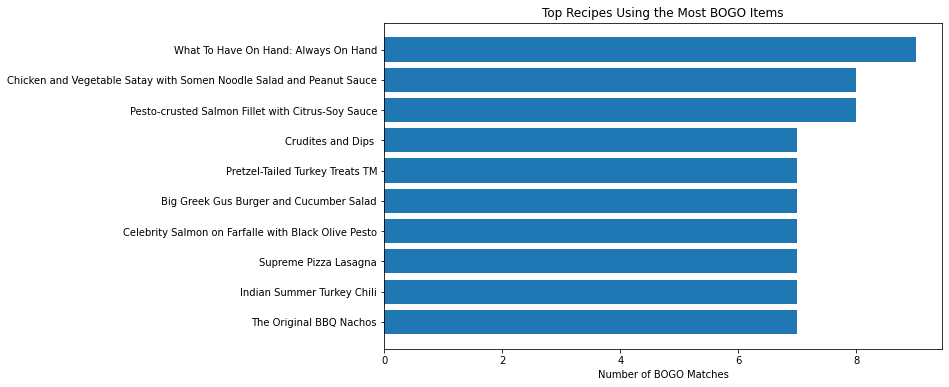

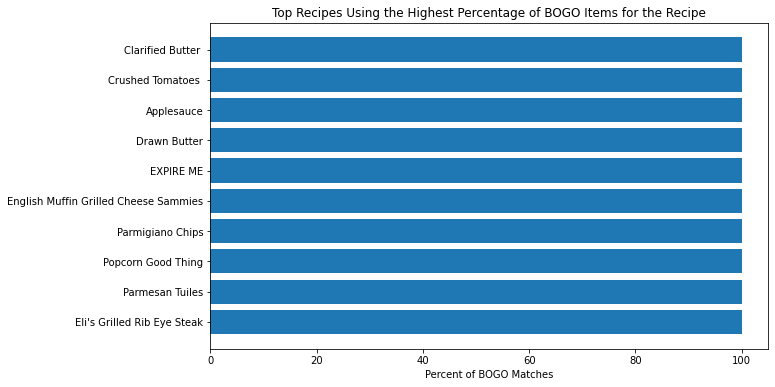

In [28]:
import matplotlib.pyplot as plt

top_recipes = df.sort_values("num_bogo_matches", ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_recipes["title"], top_recipes["num_bogo_matches"])
plt.gca().invert_yaxis()
plt.xlabel("Number of BOGO Matches")
plt.title("Top Recipes Using the Most BOGO Items")
plt.show()

df["bogo_ratio"] = df["num_bogo_matches"] / df["ingredients"].apply(len)
top_perc_recipes = df.sort_values("bogo_ratio", ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_perc_recipes["title"], top_perc_recipes["bogo_ratio"]*100)
plt.gca().invert_yaxis()
plt.xlabel("Percent of BOGO Matches")
plt.title("Top Recipes Using the Highest Percentage of BOGO Items for the Recipe")
plt.show()

The first chart shows the recipes with the most matched ingredients. This tends to favor complex recipes with more ingredients, but may cost more because of this. The second chart find the recipes that have the highest percentage of ingredients that match the BOGO items. This will show simpler recipes, at the downside of potentially finding recipes with very few ingredients that happen to match the BOGO deals that week. Because of this, I will be continuing with the first method of most matched ingredients.

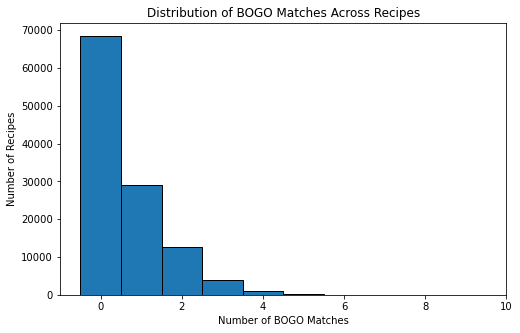

Description
 count    115762.000000
mean          0.628315
std           0.919307
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           9.000000
Name: num_bogo_matches, dtype: float64


Recipes with each Number of Matches
 0    68493
1    29133
2    12745
3     3947
4     1080
5      266
6       69
7       26
8        2
9        1
Name: num_bogo_matches, dtype: int64


In [52]:
plt.figure(figsize=(8, 5))
plt.hist(df["num_bogo_matches"], bins=range(df["num_bogo_matches"].max() + 2), align="left", edgecolor="black")
plt.xlabel("Number of BOGO Matches")
plt.ylabel("Number of Recipes")
plt.title("Distribution of BOGO Matches Across Recipes")
plt.show()

print("Description\n",df["num_bogo_matches"].describe())
print("\n")
print("Recipes with each Number of Matches\n",df["num_bogo_matches"].value_counts().sort_index())

This chart shows the number of ingredient matches per recipe. We can see that the majority of recipes do not have any matches, with recipe numbers expectedly dwindling to 0 as the number of matches rise. A notably large number of recipes have 1 or 2 matching ingredients, suggesting that Publix chooses some very commonly used items as well as many more obscure ones.

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
rayleigh,0.009645,284.303206,303.621790,0.053126,0.412535,0.0
exponpow,0.012447,122.506664,151.484539,0.007544,0.591671,0.0
norm,0.030968,344.457170,363.775753,0.062678,0.344516,0.0
expon,0.034425,153.861566,173.180150,0.111299,0.591671,0.0
chi2,0.045488,93.995509,122.973384,0.050503,0.591671,0.0


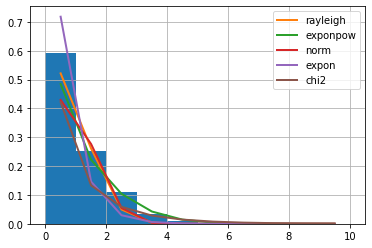

In [57]:
from fitter import Fitter, get_common_distributions
import matplotlib.pyplot as plt

data = df["num_bogo_matches"].values

f = Fitter(data, distributions=get_common_distributions(), bins=range(df["num_bogo_matches"].max() + 2))

f.fit()
f.summary()

Using the "fitter" library, we can find which distribution fits the data best. In my case when running this, the Rayleigh distribution has the lowest sum of squared error, while the Exponential Power distibution has the a low sum of squared error and a low AIC and BIC. Generally, the Rayleigh distribution seems to fit better. Since the number of matches BOGO items match the Rayleigh distribution, this confirms further than visual analysis that the data is skewed, most recipes have very few matches and a small tail of recipes overlap better with the BOGO list. Notably Poisson distribution is not on this list because of the skew. This skew is most likely caused by common ingredients (oil, butter, etc.) occuring more frequently in the recipes, as well as having a higher probability of going on sale at Publix.

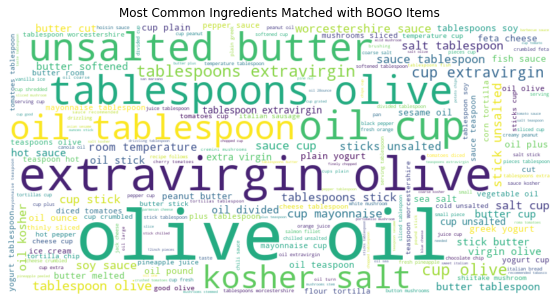

In [19]:
from wordcloud import WordCloud

all_matched = [pair[0] for matches in df["bogo_matches"] for pair in matches]
text = " ".join(all_matched)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Ingredients Matched with BOGO Items")
plt.show()

This word cloud visualizes the most commonly matched ingredients that are BOGO. This will likely display variations of very commonly used ingredients. In this week, this includes items such as oil, butter, soy sauce, and worcestershire sauce. This can be a quick way of finding staple household ingredients used in many recipes that are on sale.

The following cell show the recipes with the top matches, along with their matched ingredients. This can be used like a grocery list, while also being easy to spot where the NLP model incorrectly matched similar seeming ingredients. The next cell can be used after shopping, as it contains the instructions for the top recipes.

In [58]:
df_display = df[["title", "num_bogo_matches", "bogo_matches"]].sort_values("num_bogo_matches", ascending=False)
df_display.head(7).style.set_properties(**{"text-align": "left"})

,title,num_bogo_matches,bogo_matches
66908,What To Have On Hand: Always On Hand,9,"[('plum tomatoes', 'smt tomatoes'), ('peanut butter', 'skippy peanut butter'), ('olives', 'bertolli olive oil'), ('soy sauce', 'bertolli sauce'), ('various pastas', 'barilla pasta'), ('vegetable', 'green giant vegetables'), ('sundried tomatoes', 'sunset angel sweet tomatoes'), ('dry mushrooms', 'greenwise organic sliced white mushrooms'), ('potatoes', 'wise potato chips')]"
104763,Chicken and Vegetable Satay with Somen Noodle Salad and Peanut Sauce,8,"[('3 tablespoons soy sauce', 'tabasco sauce'), ('1 tablespoon fish sauce', 'tabasco sauce'), ('3 tablespoons sweet soy sauce', 'tabasco sauce'), ('peanut sauce recipe follows', 'skippy peanut butter'), ('somen noodle salad recipe follows', 'nissin top ramen ramen noodle soup'), ('1 12 tablespoons fish sauce', 'tabasco sauce'), ('1 cup peanut butter', 'skippy peanut butter'), ('2 tablespoons sweet soy sauce', 'tabasco sauce')]"
95192,Pesto-crusted Salmon Fillet with Citrus-Soy Sauce,8,"[('olive oil', 'bertolli olive oil'), ('pesto recipe follows', 'barilla pesto'), ('2 tablespoons pine nuts', 'planters mixed nuts'), ('12 cup olive oil', 'bertolli olive oil'), ('1 tablespoon olive oil', 'bertolli olive oil'), ('2 tablespoons soy sauce', 'tabasco sauce'), ('1 12 tablespoons fish sauce', 'tabasco sauce'), ('1 cup olive oil', 'bertolli olive oil')]"
48702,Crudites and Dips,7,"[('2 tablespoons light olive oil plus extra for drizzling', 'bertolli olive oil'), ('sea salt to taste', 'sanders milk chocolate sea salt caramels'), ('1 tablespoon extra virgin olive oil', 'bertolli olive oil'), ('cherry tomatoes', 'sunset angel sweet tomatoes'), ('tortilla chips cool flavor or the blue corn variety', 'tortilleria mi nia tortilla chips'), ('mini oat crackers or mini rice cakes', 'hostess snacks cakes'), ('tortilla chips cut 1 large tortilla into 8 slices place on a baking sheet and cook at 350f for 10 minutes', 'tortilleria mi nia tortilla chips')]"
71706,Pretzel-Tailed Turkey Treats TM,7,"[('3 tablespoons butter or margarine', 'country crock spread or butter sticks'), ('6 cups kelloggs cocoa krispies cereal', 'kelloggs special k cereal'), ('creamy peanut butter', 'skippy peanut butter'), ('kelloggs cocoa krispies cereal', 'kelloggs special k cereal'), ('pretzel twists', 'dots pretzels'), ('pretzel sticks', 'dots pretzels'), ('assorted candies', 'werthers original caramel candies')]"
87920,Big Greek Gus Burger and Cucumber Salad,7,"[('14 cup greek yogurt', 'yoplait original yogurt'), ('kosher salt and black pepper', 'sanders milk chocolate sea salt caramels'), ('4 hamburger buns', 'ball park hot dog buns'), ('mayonnaise for spreading', 'hellmanns mayonnaise'), ('12 cup crumbled feta', 'athenos crumbled feta cheese'), ('olive oil', 'bertolli olive oil'), ('kosher salt', 'sanders milk chocolate sea salt caramels')]"
90840,Celebrity Salmon on Farfalle with Black Olive Pesto,7,"[('3 tablespoons soy sauce', 'tabasco sauce'), ('5 5ounce fresh salmon fillets', 'publix alaskan panko pollock fillets'), ('14 cup plus 1 tablespoon extravirgin olive oil', 'bertolli olive oil'), ('1 14 pounds farfalle bowtie pasta', 'rummo pasta'), ('1 tablespoon olive oil', 'bertolli olive oil'), ('1 dozen cherry tomatoes', 'sunset angel sweet tomatoes'), ('olive oil for sauteing', 'bertolli olive oil')]"


In [59]:
df_display = df[["title", "num_bogo_matches", "instructions"]].sort_values("num_bogo_matches", ascending=False)
df_display.head(7).style.set_properties(**{"text-align": "left"})

,title,num_bogo_matches,instructions
66908,What To Have On Hand: Always On Hand,9,Check shelf life for pantry items below.
104763,Chicken and Vegetable Satay with Somen Noodle Salad and Peanut Sauce,8,"Using a food processor, combine the mirin, soy sauce, fish sauce, rice vinegar, lime juice, garlic, sambal, sweet soy sauce, sake, and green onions. Blend at high speed until the mixture achieves a smooth consistency. Divide the marinade in half and place in 2 separate pans. Trim the chicken breast, removing all of the fat and sinew. Cut the chicken lengthwise into 4 inch strips. Stab the skewers through the chicken and soak in 1 of the pans filled with marinade for at least 2 hours. Thread the prepared shiitake caps, tomatoes, onion, and eggplant onto a new set of skewers, and soak in the other pan of marinade. Let sit for at least 2 hours. When other elements are ready, grill skewers over medium high heat for 3 to 4 minutes per side. On a large plate, spread the Peanut Sauce to cover about 3/4 of the plate. Place a radicchio cup in the center of the plate and fill with the Somen Noodle Salad. Place 4 chicken skewers and 1 vegetable skewer on the plate and garnish with the remaining 2 tablespoons green onions and peanuts. Prepare a medium saucepot coated with oil over medium heat. When the oil shimmers, add the shallots and saute until carmelized. Deglaze the pan with the fish sauce and add the coconut milk, peanut butter, sweet soy sauce, and sambal. Stir to combine and then bring to a boil for 2 minutes. Remove from heat, pour into a food processor, and blend until smooth. Bring a large pot filled with salted water to a boil, add the somen noodles cook for about 2 minutes. Immediately transfer the noodles to a bowl filled with ice water to stop the cooking. Drain the noodles and drizzle with the canola oil to prevent them from sticking. In a large mixing bowl, combine the noodles, radicchio, carrots, 2 tablespoons of green onions, peanut sauce, sweet soy sauce, lime juice, salt and pepper. Mix well to coat the noodles. Place in the refrigerator until ready for use. Beverage suggestion: Thai style beers like Singha and Limonade from France (like sprite) to make shandies/panaches."
95192,Pesto-crusted Salmon Fillet with Citrus-Soy Sauce,8,"Preheat oven to 350 degrees F. Heat a 12-inch non-stick saute pan over a high flame. Season the salmon fillets with salt and pepper. Add a small amount of oil to the pan and sear both sides of the salmon quickly, just a few seconds on each side, leaving the fish very rare. Remove the pan from the heat, and place the fish on a work surface. Wipe out the pan and reserve for later use. Spread a 1/4-inch layer of pesto evenly over 1 side of the fillet. Sprinkle the top of the pesto with a light, thin dusting of fresh bread crumbs. Carefully invert each fillet into the pan and place it over a medium flame. Toast the bread coating, adding tiny bits of butter to the pan that will melt into the salmon underneath. Once the bread is toasted (after about 1 minute), place the pan in the oven for about 3 minutes, just to heat the fish through. To serve, mound 1/6 of the spinach in the center of a warm dinner plate. Invert 1 salmon fillet onto the spinach, crust-side up, and ladle citrus soy sauce around the sides. Place 1 orange segment on top of 1 grapefruit segment in the sauce at 3 different points on the plate. In the bowl of a food processor place, pine nuts, garlic, salt, and pepper. Add the basil and process again. With the motor running, add the oil in a stream slowly, scraping down the sides of the bowl occasionally. Add bread crumbs a little at a time, just enough to make pesto spreadable. Process and repeat until the pesto is the right consistency. Remove from food processor and set aside until ready to use. In a non-reactive saucepan, saute the ginger in 1 tablespoon olive oil for 1 minute over medium heat. Add the shallot and garlic and continue cooking for 1 minute longer. Deglaze the pan wi

## Conclusion

With this data, we can see how ingredients chosen by Publix compare in a large dataset of recipes. Some very commonly used items, and many more uncommon ones, are put on sale.

Also identified are the most common ingredients that are on sale for that week, and the top recipes with the most matched ingredients with an ingredient list to shop for and instructions on how to cook the recipe.

### Potential Improvements

1. NLP accuracy (Decrease misidentified matches)

    -The threshold for the NLP model can be fine tuned further 

    -An even more accurate but computationally intensive model can be used.

2. Automation

    -AWS Lambda among other methods can be used to automatically run the BOGO web scraper once per week to update the BOGO list.
    
3. User Interface

    -An application or web page can be created to make it easier for users to use and see the outcome of the program

4. Additional Features

    -Prices for the BOGO items can be summed and displayed.

    -Sales other than BOGO can be included.

    -More grocery stores can be added.

    -USDA FoodData Central API can be used to retrieve nutrition data for ingredients.

Thank you.